# **Fiber photometry of SNc/SNr dopamine and GABA neuron responses to optogenetic STN and PPN stimulation in Parkinson's disease**

This tutorial shows how to access and process data from [DANDI:001528](https://dandiarchive.org/dandiset/001528/draft) for the study detailed in [*"Parkinson's Disease-vulnerable and -resilient dopamine neurons display opposite responses to excitatory input"*](https://www.biorxiv.org/content/10.1101/2025.06.03.657460v1)

## Study Overview

This dataset contains fiber photometry recordings examining differential responses of Parkinson's disease (PD)-vulnerable and -resilient dopamine neuron subtypes to excitatory input in freely-moving mice. The study investigates how excitatory inputs from the subthalamic nucleus (STN) and pedunculopontine nucleus (PPN) differentially modulate distinct dopaminergic and GABAergic populations in the substantia nigra (SNc/SNr) and their striatal projections. Using genetically-targeted calcium imaging with GCaMP6f/8f indicators and GRAB_DA sensors, the dataset captures activity across five experimental groups: 
1. SNr GABAergic neurons, 
2. SNc pan-dopaminergic neurons, 
3. Parkinson's-vulnerable Anxa1+ and -resilient Vglut2+ dopamine subtypes, 
4. striatal dopamine release in dorsolateral and tail striatum, and 
5. dopaminergic axon terminals. 

ChrimsonR-mediated optogenetic stimulation (635nm, 5mW) was delivered to STN and/or PPN at varying frequencies (5, 10, 20, 40 Hz) and durations (250ms, 1s, 4s) to probe circuit-specific responses. Key findings demonstrate that excitatory inputs evoke frequency-dependent excitation in SNr GABA neurons but heterogeneous, multiphasic responses in dopamine populations. Critically, PD-resilient Vglut2+ dopamine neurons show excitatory responses to STN/PPN input, while vulnerable Anxa1+ neurons are inhibited, revealing opposite functional properties between these subtypes. Striatal recordings show differential regional responses, with increased dopamine release in caudal striatum but inhibition followed by rebound in dorsolateral striatum. Each session includes raw and processed fiber photometry signals (demodulated calcium/isosbestic traces, downsampled signals, and DF/F), precisely-timed optogenetic stimulation epochs, and behavioral videos where available.

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Fiber Photometry Data and Metadata](#photometry)
4. [Optogenetic Stimulus and Metadata](#ogen)
5. [Session Type 1: Varying Duration Optogenetic Stimulation](#session1)
6. [Session Type 2: Varying Frequency Optogenetic Stimulation](#session2)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [ ]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [188]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    
    with DandiAPIClient() as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )
        
        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)
        
        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")
        
        s3_url = s3_urls[0]
    
    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}.nwb"
    
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")
    
    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [189]:
# Load session data
dandiset_id = "001528"
subject_id = "C4561"  # Example subject
session_id = "varying-duration"  # Start with first session type

# Choose data source (DANDI streaming or local)
USE_DANDI = True  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = "YOUR_DIRECTORY_PATH"  # Replace with actual path
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 SNr GABAergic neurons recordings. Mice were freely moving on a plastic tub. Simultaneous passive optogenetic stimulation and fiber photometry recordings were conducted during the first two days. Excitatory inputs from either the STN or PPN to SN were stimulated. Recordings of GCaMP6f fluorescence signal captured pan-GABA activity in the SNr in VGLUT2-Cre x VGAT-Flp mice.
Session description:
 The subject is placed in a plastic tub and is recorded for 3.5 minutes. The subject receives a 40 Hz stimulation at various durations (i.e. 250ms, 1s and 4s) 5 times for each duration) with an inter-stimulus interval (ISI) of 10s. 
Session start time:
 2024-01-18 10:24:56-00:01


In [190]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: C4561
Age: P6W
Strain: Mus musculus
Genotype: VGlut2-cre x VGAT-flp
Sex: F


---

# 3. Fiber Photometry Data and Metadata <a id="photometry"></a>

## Fiber Photometry Metadata

In [191]:
print("=== FIBER PHOTOMETRY METADATA ===")
print("All fiber photometry metadata are stored in the fiber_photometry module in lab_meta_data:")
nwbfile.lab_meta_data["fiber_photometry"]

=== FIBER PHOTOMETRY METADATA ===
All fiber photometry metadata are stored in the fiber_photometry module in lab_meta_data:


,location,excitation_wavelength_in_nm,emission_wavelength_in_nm,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,emission_filter,excitation_filter
id,,,,,,,,,,
0,SNr,465.0,515.0,GCaMP6f_SNr abc.Indicator at 0x2222092835136\nFields:\n description: GCaMP6f calcium sensor in SNr GABAergic neurons\n label: GCaMP6f\n manufacturer: Addgene\n viral_vector_injection: viral_vector_injection_SNr abc.ViralVectorInjection at 0x2222092834800\nFields:\n ap_in_mm: -3.3\n description: Viral injection of GCaMP6f in SNr.\n dv_in_mm: -4.6\n hemisphere: left\n location: SNr\n ml_in_mm: -1.3\n reference: bregma at the cortical surface\n viral_vector: viral_vector_gcamp6f abc.ViralVector at 0x2222092834128\nFields:\n construct_name: AAV1-Ef1a-fDIO-GCaMP6f\n description: AAV1 viral vector expressing GCaMP6f calcium sensor under EF1a promoter for fiber photometry recording in SNr\n manufacturer: Addgene (catalog number 1283125)\n titer_in_vg_per_ml: 4000000000000.0\n\n volume_in_uL: 0.3\n\n,optical_fiber_SNr abc.OpticalFiber at 0x2222092842192\nFields:\n description: Chronically implanted optic fiber.\n fiber_insertion: fiber_insertion abc.FiberInsertion at 0x2222092841856\nFields:\n hemisphere: left\n insertion_position_ap_in_mm: -3.3\n insertion_position_dv_in_mm: -4.4\n insertion_position_ml_in_mm: -1.4\n position_reference: bregma\n\n model: optical_fiber_model_1 abc.OpticalFiberModel at 0x2222092841520\nFields:\n active_length_in_mm: 6.0\n core_diameter_in_um: 400.0\n description: Chronically implantable optic fiber.\n ferrule_diameter_in_mm: 1.25\n ferrule_name: black ceramic ferrule\n manufacturer: RWD\n model_number: <model of the optical fiber>\n numerical_aperture: 0.39\n\n serial_number: <serial number of the optical fiber>\n,excitation_source_calcium_signal abc.ExcitationSource at 0x2222092841184\nFields:\n description: excitation source for the sensor's fluorescence signal (465nm) modulated at 210 Hz.\n model: excitation_source_model_calcium abc.ExcitationSourceModel at 0x2222092840848\nFields:\n description: excitation source for GCaMP6f sensor.\n excitation_mode: one-photon\n manufacturer: Tucker-Davis Technologies\n model_number: RZ5P or RZ10x\n source_type: LED\n wavelength_range_in_nm: [460. 490.]\n\n,photodetector abc.Photodetector at 0x2222092842864\nFields:\n description: <description of the photodetector>\n model: photodetector_model abc.PhotodetectorModel at 0x2222092842528\nFields:\n description: <description of the photodetector model>\n detector_type: Silicon photodiode\n gain: 0.38\n gain_unit: A/W\n manufacturer: <manufacturer of the photodetector>\n model_number: <model of the photodetector>\n wavelength_range_in_nm: [500. 540.]\n\n serial_number: <serial number of the photodetector>\n,dichroic_mirror abc.DichroicMirror at 0x2222092839840\nFields:\n description: dichroic mirror for GCaMP6f fluorescence signal.\n model: dichroic_mirror_model abc.DichroicMirrorModel at 0x2222092839504\nFields:\n description: dichroic mirror model for GCaMP6f fluorescence signal.\n manufacturer: <manufacturer of the dichroic mirror>\n model_number: <model of the dichroic mirror>\n\n serial_number: <serial number of the dichroic mirror>\n,emission_filter abc.BandOpticalFilter at 0x2222092840512\nFields:\n description: emission filter for GCaMP6f fluorescence signal.\n model: emission_filter_model abc.BandOpticalFilterModel at 0x2222092840176\nFields:\n bandwidth_in_nm: 40.0\n center_wavelength_in_nm: 520.0\n description: emission filter model for GCaMP6f fluorescence signal.\n filter_type: Bandpass\n manufacturer: <manufacturer of the emission filter>\n model_number: <model of the emission filter>\n\n,excitation_filter abc.BandOpticalFilter at 0x2222061498960\nFields:\n description: excitation filter for GCaMP6f fluorescence signal.\n model: excitation_filter_model abc.BandOpticalFilterModel at 0x2222061489680\nFields:\n bandwidth_in_nm: 90.0\n center_wavelength_in_nm: 445.0\n description: excitation filter model for GC

In [192]:
print("=== FP SETUP INFORMATION ===")
print("Components used in fiber photometry setup:")
for key in nwbfile.devices.keys():
    if "BehavioralCamera" in key or "optogenetic" in key:
        continue
    print(key)

=== FP SETUP INFORMATION ===
Components used in fiber photometry setup:
dichroic_mirror
emission_filter
excitation_filter
excitation_source_calcium_signal
excitation_source_isosbestic_control
optical_fiber_SNr
photodetector


In [193]:
nwbfile.devices["excitation_source_calcium_signal"]

Data type,float64
Shape,"(2,)"
Array size,16.00 bytes


In [194]:
nwbfile.devices["excitation_source_calcium_signal"]

Data type,float64
Shape,"(2,)"
Array size,16.00 bytes


In [195]:
nwbfile.devices["excitation_filter"]

excitation_filter abc.BandOpticalFilter at 0x2222061498960
Fields:
  description: excitation filter for GCaMP6f fluorescence signal.
  model: excitation_filter_model abc.BandOpticalFilterModel at 0x2222061489680
Fields:
  bandwidth_in_nm: 90.0
  center_wavelength_in_nm: 445.0
  description: excitation filter model for GCaMP6f fluorescence signal.
  filter_type: Bandpass
  manufacturer: <manufacturer of the excitation filter>
  model_number: <model of the excitation filter>

In [196]:
nwbfile.devices["emission_filter"]

emission_filter abc.BandOpticalFilter at 0x2222092840512
Fields:
  description: emission filter for GCaMP6f fluorescence signal.
  model: emission_filter_model abc.BandOpticalFilterModel at 0x2222092840176
Fields:
  bandwidth_in_nm: 40.0
  center_wavelength_in_nm: 520.0
  description: emission filter model for GCaMP6f fluorescence signal.
  filter_type: Bandpass
  manufacturer: <manufacturer of the emission filter>
  model_number: <model of the emission filter>

In [197]:
nwbfile.devices["dichroic_mirror"]

dichroic_mirror abc.DichroicMirror at 0x2222092839840
Fields:
  description: dichroic mirror for GCaMP6f fluorescence signal.
  model: dichroic_mirror_model abc.DichroicMirrorModel at 0x2222092839504
Fields:
  description: dichroic mirror model for GCaMP6f fluorescence signal.
  manufacturer: <manufacturer of the dichroic mirror>
  model_number: <model of the dichroic mirror>

  serial_number: <serial number of the dichroic mirror>

In [198]:
nwbfile.devices["photodetector"]

Data type,float64
Shape,"(2,)"
Array size,16.00 bytes


In [199]:
for key in nwbfile.devices.keys():
    if "optical_fiber" in key:
        optical_fiber = nwbfile.devices[key]
optical_fiber

optical_fiber_SNr abc.OpticalFiber at 0x2222092842192
Fields:
  description: Chronically implanted optic fiber.
  fiber_insertion: fiber_insertion abc.FiberInsertion at 0x2222092841856
Fields:
  hemisphere: left
  insertion_position_ap_in_mm: -3.3
  insertion_position_dv_in_mm: -4.4
  insertion_position_ml_in_mm: -1.4
  position_reference: bregma

  model: optical_fiber_model_1 abc.OpticalFiberModel at 0x2222092841520
Fields:
  active_length_in_mm: 6.0
  core_diameter_in_um: 400.0
  description: Chronically implantable optic fiber.
  ferrule_diameter_in_mm: 1.25
  ferrule_name: black ceramic ferrule
  manufacturer: RWD
  model_number: <model of the optical fiber>
  numerical_aperture: 0.39

  serial_number: <serial number of the optical fiber>

In [200]:
print("=== FLUORESCENT CALCIUM SENSOR ===")
print("Fluorescent calcium sensor used in this experiment:")
nwbfile.lab_meta_data["fiber_photometry"].fiber_photometry_indicators

=== FLUORESCENT CALCIUM SENSOR ===
Fluorescent calcium sensor used in this experiment:


fiber_photometry_indicators abc.FiberPhotometryIndicators at 0x2222092835472
Fields:
  indicators: {
    GCaMP6f_SNr <class 'abc.Indicator'>
  }

## Raw (modulated) FiberPhotometry Series

In [201]:
print("=== ACQUISITION MODULE ===\n")
for name, acq in nwbfile.acquisition.items():
    print(f"{name} - {acq.description}")
    if "raw_signal" in name:
        raw_signal_series_name = name

=== ACQUISITION MODULE ===

BehavioralVideo - Video recording of the mouse's behavior. Recorded using a camera mounted on the ceiling above the chambers.

raw_signal_SNr - The raw modulated fluorescence signal from GCaMP6f calcium indicator in SNr GABAergic neurons, excited at 465nm and 405nm, respectively.


In [202]:
# Access raw fiber photometry data
raw_signal = nwbfile.acquisition[raw_signal_series_name]

print("=== RAW FIBER PHOTOMETRY SIGNAL ===")
print(f"Name: {raw_signal.name}")
print(f"Description: {raw_signal.description}")
print(f"Data shape: {raw_signal.data.shape}")
print(f"Sampling rate: {raw_signal.rate} Hz")
print(f"Duration: {raw_signal.data.shape[0] / raw_signal.rate:.2f} seconds")

=== RAW FIBER PHOTOMETRY SIGNAL ===
Name: raw_signal_SNr
Description: The raw modulated fluorescence signal from GCaMP6f calcium indicator in SNr GABAergic neurons, excited at 465nm and 405nm, respectively.
Data shape: (1580544,)
Sampling rate: 6103.515625 Hz
Duration: 258.96 seconds


In [203]:
nwbfile.acquisition[raw_signal_series_name]

raw_signal_SNr abc.FiberPhotometryResponseSeries at 0x2222092833456
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1580544,), type "<f4">
  description: The raw modulated fluorescence signal from GCaMP6f calcium indicator in SNr GABAergic neurons, excited at 465nm and 405nm, respectively.
  fiber_photometry_table_region: fiber_photometry_table_region <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 6103.515625
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: a.u.

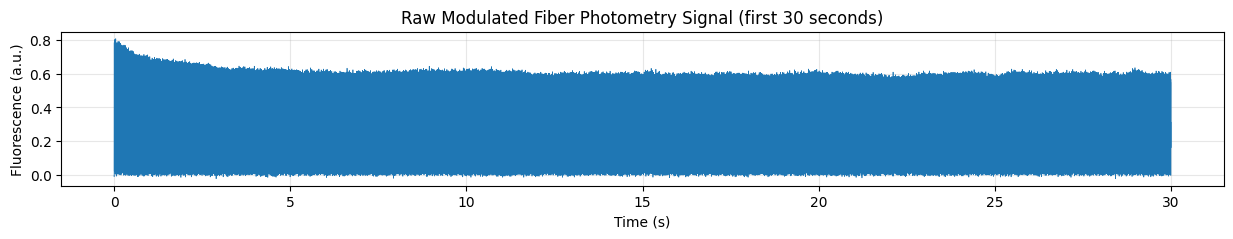

In [204]:
# Plot raw acquisition signal (simple view)
data = raw_signal.data[:]
timestamps = raw_signal.get_timestamps()

# Show first 30 seconds
end_idx = int(30 * raw_signal.rate)
time_subset = timestamps[:end_idx]
data_subset = data[:end_idx]

plt.figure(figsize=(15, 2))
plt.plot(time_subset, data_subset, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Raw Modulated Fiber Photometry Signal (first 30 seconds)')
plt.grid(True, alpha=0.3)
plt.show()

## Processed FiberPhotometry Series

In [205]:
print("=== OPHYS PROCESSING MODULE ===")
processed_fp = nwbfile.processing["ophys"]
print(processed_fp.description, "\n")
for name, fp in processed_fp.items():
    print("-"*20)
    print(f"Name: {fp.name}")
    print(f"Description: {fp.description}")
    print(f"Sampling rate: {fp.rate} Hz")
    print(f"Metadata:")
    fp_metadata = fp.fiber_photometry_table_region[:]
    print(f"  Location: {fp_metadata['location'].values[0]}")
    print(f"  Excitation wavelength: {fp_metadata['excitation_wavelength_in_nm'].values[0]} nm")
    

=== OPHYS PROCESSING MODULE ===
Processed fiber photometry signals 

--------------------
Name: deltaF_over_F_SNr
Description: The deltaF/F signal from GCaMP6f calcium indicator in SNr GABAergic neurons, excited at 465nm and calculated as (Gc - fitted_af) / fitted_af.
Sampling rate: 100.0 Hz
Metadata:
  Location: SNr
  Excitation wavelength: 465.0 nm
--------------------
Name: demodulated_calcium_signal_SNr
Description: The demodulated fluorescence signal from GCaMP6f calcium indicator in SNr GABAergic neurons, excited at 465nm and demodulated at 330Hz.
Sampling rate: 6103.5156 Hz
Metadata:
  Location: SNr
  Excitation wavelength: 465.0 nm
--------------------
Name: demodulated_isosbestic_control_SNr
Description: The demodulated fluorescence signal from GCaMP6f for isosbestic control in SNr GABAergic neurons, excited at 405nm and demodulated at 210Hz.
Sampling rate: 6103.5156 Hz
Metadata:
  Location: SNr
  Excitation wavelength: 405.0 nm
--------------------
Name: downsampled_calcium_s

## Behavioral Video
NB: not all sessions have behavioral video data

In [206]:
# Access behavioral video information
if "BehavioralVideo" in nwbfile.acquisition:
    video = nwbfile.acquisition["BehavioralVideo"]

    print("=== BEHAVIORAL VIDEO ===")
    print(f"Video file path: {video.external_file[0]}")
    print(f"Description: {video.description}")
    print(f"Video start: {video.timestamps[0]} seconds")
    print(f"Video end: {video.timestamps[-1]} seconds")
else:
    print("No behavioral video found in this session.")

=== BEHAVIORAL VIDEO ===
Video file path: sub-C4561_ses-varying-durations_image\5edc8957-c811-4c13-bc52-491745c3f527_external_file_0.mp4
Description: Video recording of the mouse's behavior. Recorded using a camera mounted on the ceiling above the chambers.

Video start: 39.0 seconds
Video end: 249.001 seconds


In [207]:
video.device  # Display video device information

BehavioralCamera pynwb.device.Device at 0x2222062094096
Fields:
  description: Camera mounted on ceiling above chambers for behavioral recording

---

# 4. Optogenetic Stimulus and Metadata <a id="ogen"></a>


## Optogenetic Metadata

In [208]:
print("=== OPTOGENETIC STIMULUS METADATA ===")
print("All optogenetic stimulus metadata are stored in the optogenetic_experiment_metadata module in lab_meta_data:")
nwbfile.lab_meta_data["optogenetic_experiment_metadata"]

=== OPTOGENETIC STIMULUS METADATA ===
All optogenetic stimulus metadata are stored in the optogenetic_experiment_metadata module in lab_meta_data:


,effector,excitation_source
id,,
0,chrimsonR_PPN abc.Effector at 0x2222092838496\nFields:\n description: ChrimsonR opsin used for optogenetic stimulation injected into the PPN.\n label: ChrimsonR-tdTomato\n manufacturer: Addgene\n viral_vector_injection: viral_vector_injection_PPN abc.ViralVectorInjection at 0x2222061494480\nFields:\n ap_in_mm: -4.48\n description: Viral injection into the Pedunculopontine Nucleus (PPN).\n dv_in_mm: -3.75\n hemisphere: left\n location: PPN\n ml_in_mm: -1.1\n reference: bregma at the cortical surface\n viral_vector: viral_vector_ogen abc.ViralVector at 0x2222061495440\nFields:\n construct_name: pAAV-Syn-FLEX-rc[ChrimsonR-tdTomato] (AAV5)\n description: pAAV-Syn-FLEX-rc[ChrimsonR-tdTomato] (AAV5) viral vector was used for optogenetic experiments.\n manufacturer: Addgene (catalog number 62723)\n titer_in_vg_per_ml: 4000000000000.0\n\n volume_in_uL: 0.15\n\n,optogenetic_excitation_source abc.ExcitationSource at 0x2222061496400\nFields:\n description: Red LED device used for optogenetic stimulation.\n model: optogenetic_excitation_source_model abc.ExcitationSourceModel at 0x2222061494160\nFields:\n description: Red LED device used for optogenetic stimulation.\n excitation_mode: one-photon\n manufacturer: Shanghai laser\n model_number: <model of the LED device>\n source_type: LED\n wavelength_range_in_nm: [580. 680.]\n\n


In [209]:
print("=== OPTOGENETIC SETUP INFORMATION ===")
print("Components used in optogenetic setup:")
for key in nwbfile.devices.keys():
    if "optogenetic" in key:
        print(key)

=== OPTOGENETIC SETUP INFORMATION ===
Components used in optogenetic setup:
optogenetic_excitation_source


In [210]:
nwbfile.devices["optogenetic_excitation_source"]

Data type,float64
Shape,"(2,)"
Array size,16.00 bytes


In [211]:
print("=== OPSIN ===")
print("Opsin used in this experiment:")
nwbfile.lab_meta_data["optogenetic_experiment_metadata"].optogenetic_effectors

=== OPSIN ===
Opsin used in this experiment:


optogenetic_effectors abc.OptogeneticEffectors at 0x2222092838832
Fields:
  effectors: {
    chrimsonR_PPN <class 'abc.Effector'>
  }

## Optogenetic Stimulus Data

In [212]:
# Access optogenetic stimulation data
ogen_df = nwbfile.intervals["optogenetic_epochs_table"].to_dataframe()

print("=== OPTOGENETIC STIMULATION INTERVALS ===")
print(f"Total number of stimuli: {len(ogen_df)}")
print("\nFirst 5 intervals:")
ogen_df.head()

=== OPTOGENETIC STIMULATION INTERVALS ===
Total number of stimuli: 15

First 5 intervals:


,start_time,stop_time,stimulation_on,pulse_length_in_ms,period_in_ms,number_pulses_per_pulse_train,number_trains,intertrain_interval_in_ms,power_in_mW,wavelength_in_nm,optogenetic_sites,stimulus_frequency
id,,,,,,,,,,,,
0,64.586711,65.585480,True,1.0,25.0,39,1,0.0,5.0,635.0,e...,40.0
1,100.585964,101.584896,True,1.0,25.0,39,1,0.0,5.0,635.0,e...,40.0
2,136.635023,137.635922,True,1.0,25.0,40,1,0.0,5.0,635.0,e...,40.0
3,172.720456,173.720044,True,1.0,25.0,39,1,0.0,5.0,635.0,e...,40.0
4,208.785244,209.785487,True,1.0,25.0,40,1,0.0,5.0,635.0,e...,40.0


---

# 5. Session Type 1: Varying Duration Optogenetic Stimulation <a id="session1"></a>

This session contains 40 Hz optogenetic stimulation at three different durations: 250ms, 1s, and 4s.

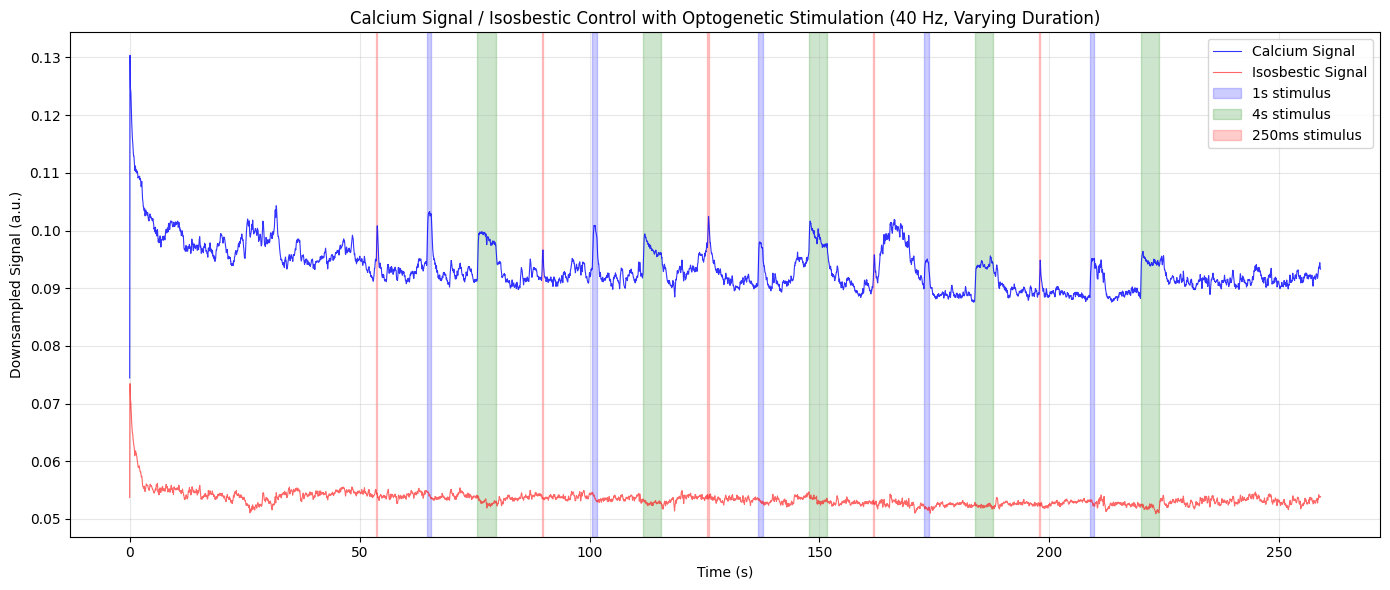

In [213]:
# Plot optogenetic stimulation and demodulated signal together
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot demodulated calcium signal
for name, fp in processed_fp.items():
    if "downsampled_calcium" in name:
        calcium_signal = fp
    elif "downsampled_isosbestic" in name:
        isosbestic_signal = fp

calcium_data = calcium_signal.data[:]
isosbestic_data = isosbestic_signal.data[:]
timestamps = calcium_signal.get_timestamps()
ax.plot(timestamps, calcium_data, color="blue", linewidth=0.8, alpha=0.8, label="Calcium Signal")
ax.plot(timestamps, isosbestic_data, color="red", linewidth=0.8, alpha=0.6, label="Isosbestic Signal")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Downsampled Signal (a.u.)')
ax.set_title('Calcium Signal / Isosbestic Control with Optogenetic Stimulation (40 Hz, Varying Duration)')
ax.grid(True, alpha=0.3)
ax.legend()

# Add stimulus intervals as faded boxes over the signal
duration_colors = {0.25: 'red', 1.0: 'blue', 4.0: 'green'}
duration_labels = {0.25: "250ms stimulus", 1.0: "1s stimulus", 4.0: "4s stimulus"}

for i, row in ogen_df.iterrows():
    duration = row['stop_time'] - row['start_time']
    # Round duration to nearest expected value for color mapping
    rounded_duration = round(duration * 4) / 4  # Round to nearest 0.25
    color = duration_colors.get(rounded_duration, 'gray')
    ax.axvspan(
        row["start_time"],
        row["stop_time"],
        color=color,
        alpha=0.2,
        label=duration_labels.get(rounded_duration, f"{rounded_duration}s"),
    )
    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

---

# 6. Session Type 2: Varying Frequency Optogenetic Stimulation <a id="session2"></a>

This session contains optogenetic stimulation at varying frequencies (5Hz, 10Hz, 20Hz, 40Hz).

In [214]:
# Load varying frequency session
session_id_freq = "varying-frequencies"

if USE_DANDI:
    nwbfile_freq, io_freq = load_nwb_from_dandi(dandiset_id, subject_id, session_id_freq)
else:
    nwbfile_freq, io_freq = load_nwb_local(local_directory, subject_id, session_id_freq)

print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile_freq.experiment_description}")
print(f"Session description:\n {nwbfile_freq.session_description}")
print(f"Session start time:\n {nwbfile_freq.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 SNr GABAergic neurons recordings. Mice were freely moving on a plastic tub. Simultaneous passive optogenetic stimulation and fiber photometry recordings were conducted during the first two days. Excitatory inputs from either the STN or PPN to SN were stimulated. Recordings of GCaMP6f fluorescence signal captured pan-GABA activity in the SNr in VGLUT2-Cre x VGAT-Flp mice.
Session description:
 The subject is placed in a plastic tub and undergoes 3 recording sessions corresponding to a fixed duration of stimulation (i.e., 250ms, 1s, and 4s). Each session lasted 8 minutes. The subject receives optogenetic stimulation at varying frequencies (5 Hz, 10 Hz , 20 Hz and 40 Hz) 5 times for each duration with an ISI of 10s. 
Session start time:
 2024-01-17 16:33:47-00:01


### Access trial table

In [215]:
trials_freq_df = nwbfile_freq.trials.to_dataframe()
print("=== TRIALS TABLE ===")
print(f"Total number of trials: {len(trials_freq_df)}")
trials_freq_df

=== TRIALS TABLE ===
Total number of trials: 3


,start_time,stop_time,tags
id,,,
0,679.0,1134.024995,[1s]
1,34.0,474.005010,[250ms]
2,1268.0,1783.031035,[4s]


### Access optogenetic stimulus

In [216]:
# Access optogenetic stimulation data
ogen_df = nwbfile_freq.intervals["optogenetic_epochs_table"].to_dataframe()

print("=== OPTOGENETIC STIMULATION INTERVALS ===")
print(f"Total number of stimuli: {len(ogen_df)}")
print("\nFirst 5 intervals:")
ogen_df.head()

=== OPTOGENETIC STIMULATION INTERVALS ===
Total number of stimuli: 60

First 5 intervals:


,start_time,stop_time,stimulation_on,pulse_length_in_ms,period_in_ms,number_pulses_per_pulse_train,number_trains,intertrain_interval_in_ms,power_in_mW,wavelength_in_nm,optogenetic_sites,stimulus_frequency
id,,,,,,,,,,,,
0,74.955981,75.206001,True,1.0,100.0,2,1,0.0,5.0,635.0,e...,10.0
1,155.955200,156.204728,True,1.0,100.0,2,1,0.0,5.0,635.0,e...,10.0
2,236.954092,237.203620,True,1.0,100.0,2,1,0.0,5.0,635.0,e...,10.0
3,318.003446,318.254612,True,1.0,100.0,2,1,0.0,5.0,635.0,e...,10.0
4,399.003320,399.253012,True,1.0,100.0,2,1,0.0,5.0,635.0,e...,10.0


### Access processed fiber photometry signal

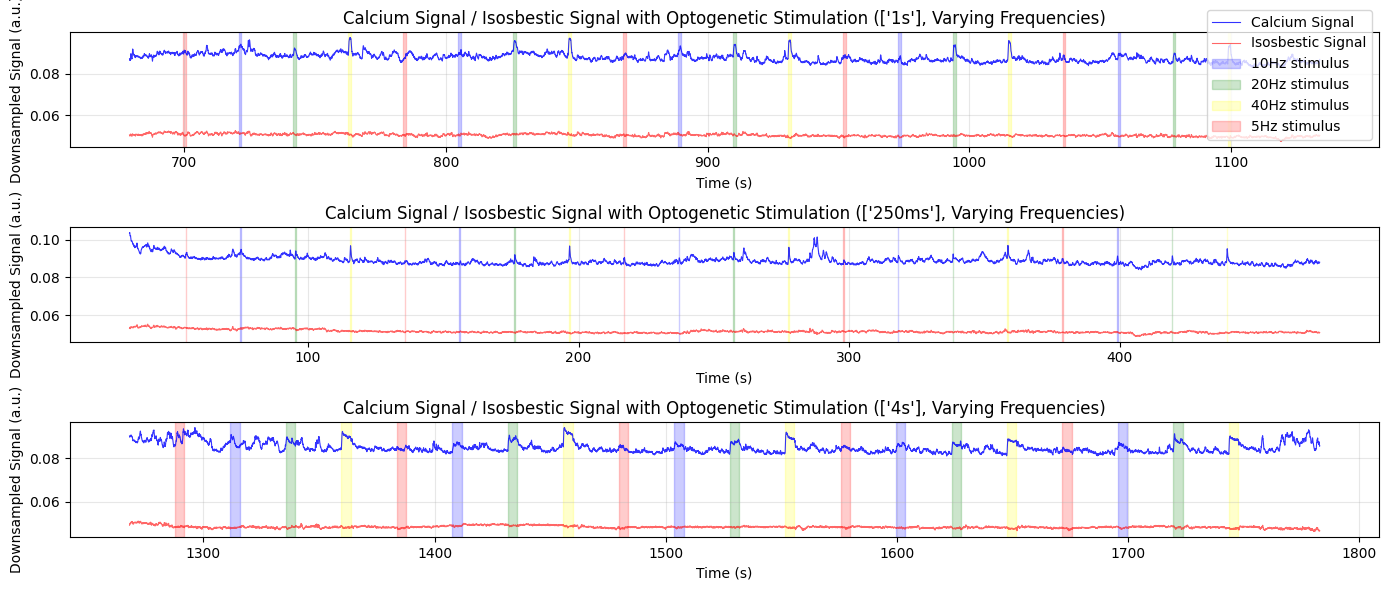

In [217]:
# Plot optogenetic stimulation and demodulated signal together
fig, axs = plt.subplots(3, 1, figsize=(14, 6))
# Plot demodulated calcium signal
processed_fp = nwbfile_freq.processing["ophys"]
for name, fp in processed_fp.items():
    if "downsampled_calcium" in name:
        calcium_signal = fp
    elif "downsampled_isosbestic" in name:
        isosbestic_signal = fp

calcium_data_freq = calcium_signal.data[:]
isosbestic_data_freq = isosbestic_signal.data[:]
timestamps_freq = calcium_signal.get_timestamps()

# Plot first trial
for i in range(3):
    trial_start_time = trials_freq_df.iloc[i]["start_time"]
    trial_end_time = trials_freq_df.iloc[i]["stop_time"]
    tag = trials_freq_df.iloc[i]["tags"]
    timestamps = timestamps_freq[(timestamps_freq >= trial_start_time) & (timestamps_freq <= trial_end_time)]
    calcium_data = calcium_data_freq[(timestamps_freq >= trial_start_time) & (timestamps_freq <= trial_end_time)]
    isosbestic_data = isosbestic_data_freq[(timestamps_freq >= trial_start_time) & (timestamps_freq <= trial_end_time)]
    # Plot demodulated calcium signal
    axs[i].plot(timestamps, calcium_data, color="blue", linewidth=0.8, alpha=0.8, label="Calcium Signal")
    axs[i].plot(timestamps, isosbestic_data, color="red", linewidth=0.8, alpha=0.6, label="Isosbestic Signal")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Downsampled Signal (a.u.)")
    axs[i].set_title(f"Calcium Signal / Isosbestic Signal with Optogenetic Stimulation ({tag}, Varying Frequencies)")
    axs[i].grid(True, alpha=0.3)

    # Add stimulus intervals as faded boxes over the signal
    frequency_colors = {5.0: "red", 10.0: "blue", 20.0: "green", 40.0: "yellow"}
    frequency_labels = {5.0: "5Hz stimulus", 10.0: "10Hz stimulus", 20.0: "20Hz stimulus", 40.0: "40Hz stimulus"}

    for r, row in ogen_df.iterrows():
        # select rows within the trial time
        if not (row["start_time"] >= trial_start_time and row["stop_time"] <= trial_end_time):
            continue
        frequency = row["stimulus_frequency"]
        color = frequency_colors.get(frequency, "gray")
        axs[i].axvspan(
            row["start_time"],
            row["stop_time"],
            color=color,
            alpha=0.2,
            label=frequency_labels.get(frequency, f"{frequency}Hz"),
        )

    handles, labels = axs[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0].legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()